## gekoppelte Pendel

In [46]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [47]:
tt = []
xx1 = []; xx2 = []
TT = [];
for i in range(1, 4+1):
    txt = loadtxt(f'punkte_loch{i}_schwebung.txt', skiprows=5, delimiter='\t')
    t_, x1_, x2_ = transpose(txt)
    T_ = t_[-1]
    tt.append(t_)
    xx1.append(x1_); xx2.append(x2_)
    TT.append(T_)

vals = list(zip(tt, xx1, xx2, TT))

In [48]:
t, x1, x2, TT = vals[4 - 1]

In [49]:
print(2*pi/t[-1])

0.0913253678369126


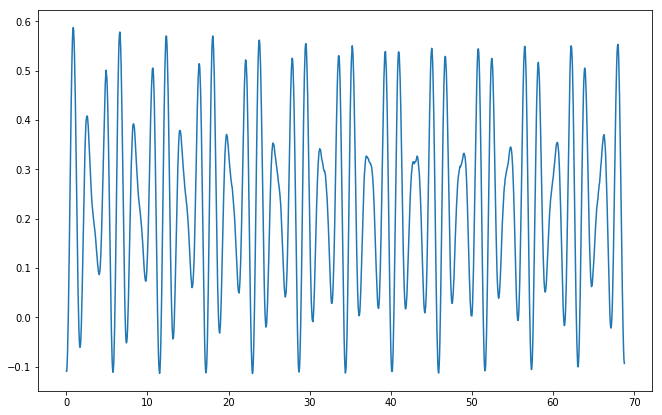

In [50]:
plt.plot(t, x1)

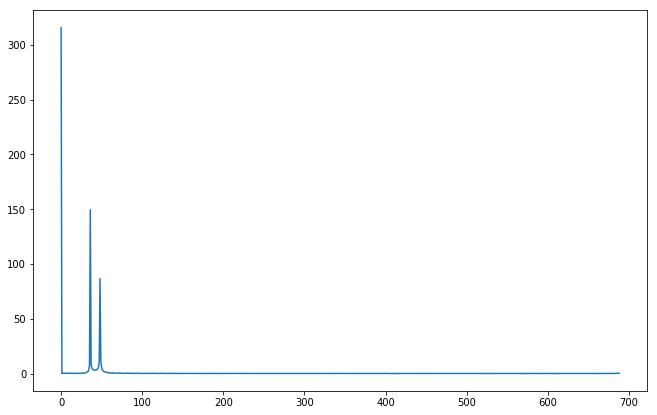

In [51]:
freq = fft.rfft(x1)
plt.plot(abs(freq))

In [52]:
n1, n2 = argpartition(-abs(freq), 2)[1:3]
print(n1, n2)

36 48


In [53]:
w1 = 2*pi/t[-1] * n1; w2 = 2*pi/t[-1] * n2
A1 = .9* sqrt(2*pi) * abs(freq[n1])/len(x1); phi1 = angle(freq[n1])
A2 = .9* sqrt(2*pi) * abs(freq[n2])/len(x1); phi2 = angle(freq[n2])

In [54]:
w1, A1, phi1
w2, A2, phi2
A = .5*(A1 + A2)

(3.2877132421288535, 0.24486099321128385, -3.077381606961986)

(4.383617656171805, 0.14193514655301742, 3.0975964105671934)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


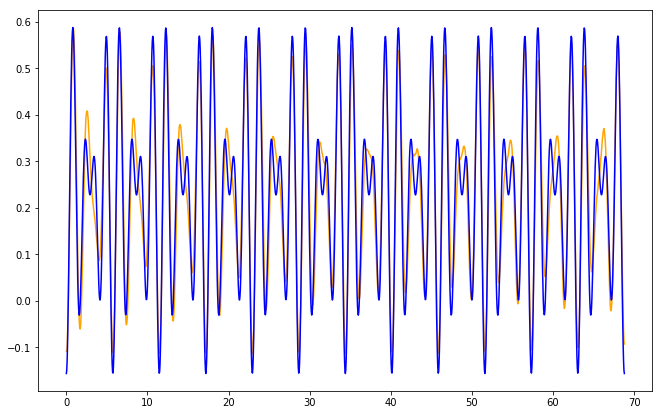

In [55]:
# _p1[0].remove(); _p2[0].remove()
_p1 = plt.plot(t, x1, 'orange')
_p2 = plt.plot(t, A * cos(w1*t + phi1) + A * cos(w2*t + phi2) + freq[0]/len(x1), 'blue')

In [56]:
2*pi/t[-1]

0.0913253678369126

In [57]:
def link(t, w1, w2, A1, A2, phi1, phi2):
    """Linearkombination von 2 Eigenmoden"""
    return A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)

def glink(t, w1, w2, A, phi1, phi2):
    """Schwebung als Linearkobination mit gleichem Koeffizient für beide Eigenmoden"""
    return A* (cos(w1*t + phi1) + cos(w2*t + phi2))

def linkd(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: exponentieller Abfall"""
    return (A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)) * exp(-g*t)

def linkd2(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: Dämpfung hängt von Geschwindigkeit ab
    (gedämpfter Oszillator)"""
    return A1*cos(w1*t + phi1)*exp(-g*w1*t) + A2*cos(w2*t + phi2)*exp(-g*w2*t)

def schweb(t, wi, wa, B, phii, phia):
    """Schwebung durch einhüllende Welle und schmelle Oszillation.
    Mathematisch äquivalent zu `glink`"""
    return B * cos(wa*t + phia) * cos(wi*t + phii)

In [58]:
a1 = x1 - mean(x1)

### fitten Schwebung direkt

In [59]:
wa = (w1 - w2)/2; wi = (w1 + w2)/2
p0 = [(w1 - w2)/2, (w1 + w2)/2, 2*A, (phi1 - phi2)/2, (phi1 + phi2)/2]
popt, pcov = scipy.optimize.curve_fit(schweb, t, a1, p0=p0,
                                      maxfev=300)

wi_, wa_, B_, phii_, phia_ = popt
err_wi, err_wa, err_B, err_phii, err_phia = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - p0

-0.5556373778942705 +- 1.2635333069767912e-07
3.836860127842675 +- 1.1616838449135382e-07
0.34459206210430515 +- 5.5867144178455594e-06
-2.8119050019703438 +- 0.00019864801939342147
-0.12497565868217937 +- 0.00018409857393033576


array([-0.00768517,  0.00119468, -0.04220408,  0.27558401, -0.13508306])

chi^2: 1.6355605388154135


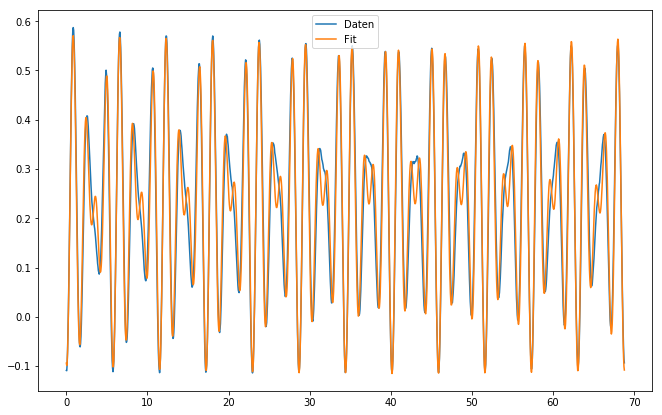

In [60]:
_ = plt.plot(t, x1)
fit = vectorize(schweb)(t, wi_, wa_, B_, phii_, phia_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten Summe der Eigenmoden

In [61]:
popt, pcov = scipy.optimize.curve_fit(glink, t, a1, p0=[w1, w2, A, phi1, phi2],
                                      maxfev=200)
w1_, w2_, A_, phi1_, phi2_ = popt
err_w1, err_w2, err_A, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A, phi1, phi2]

3.281222720918917 +- 2.4111833274237934e-07
4.392497545453028 +- 2.4392169849848735e-07
0.17229602670313915 +- 1.3966784628297606e-06
-2.936879576105281 +- 0.0003807768647408442
2.6869280637835424 +- 0.00038471431296373357


array([-0.00649052,  0.00887989, -0.02110204,  0.14050203, -0.41066835])

chi^2: 1.6355605387596195


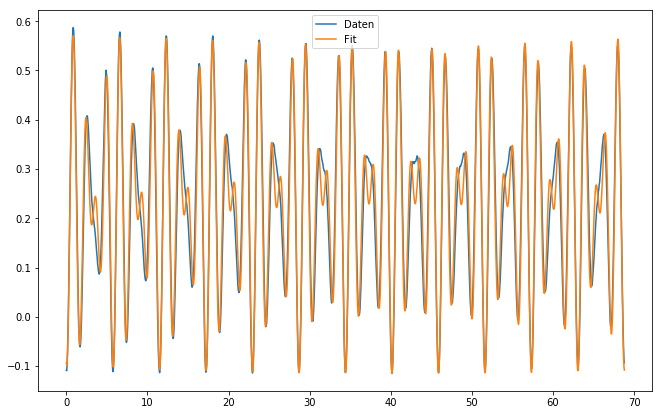

In [62]:
_ = plt.plot(t, x1)
fit = vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1))
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten linearkombination der Eigenmoden

In [66]:
popt, pcov = scipy.optimize.curve_fit(link, t, a1, p0=[w1, w2, A1, A2, phi1, phi2],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2]

3.280843779536139 +- 1.3720779581402944e-09
4.391821473188037 +- 3.964740833469454e-09
0.2166266292031968 +- 2.5555668294328333e-08
0.1281824446472189 +- 2.5438927597669545e-08
-2.9243412200208274 +- 2.1665011515103488e-06
2.709442023962094 +- 6.252526809689876e-06


array([-0.00686946,  0.00820382, -0.02823436, -0.0137527 ,  0.15304039,
       -0.38815439])

chi^2: 0.1550397651154722


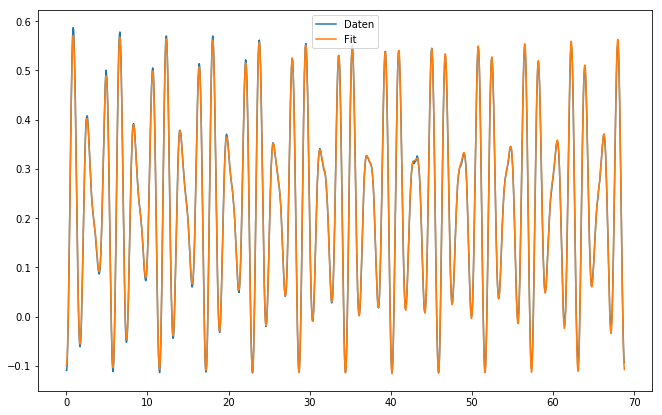

In [64]:
_ = plt.plot(t, x1)
fit = vectorize(link)(t, w1_, w2_, A1_, A2_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### because we can: Linearkombination mit Dämpfung

3.2808384878899 +- 3.67e-10
4.3918343985602 +- 1.06e-09
0.22408815331336 +- 2.21e-08
0.13257539598638 +- 1.24e-08
-2.924394146824 +- 5.6e-07
2.7105547483559 +- 1.62e-06
0.00099244746457618 +- 2.62e-10

Differenzen: [-0.00687475  0.00821674 -0.02077284 -0.00935975  0.15298746 -0.38704166
 -0.99900755]

chi^2: 0.08012231434818741


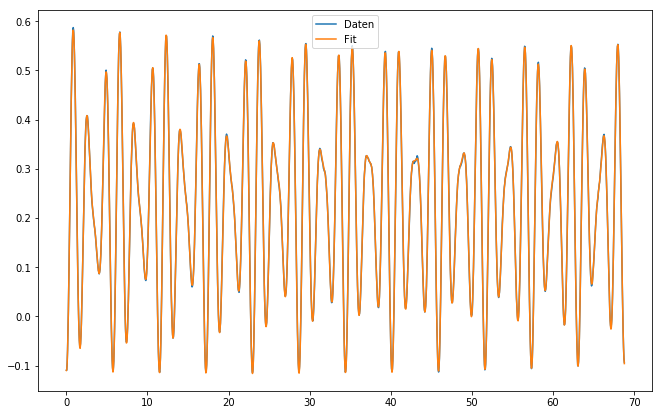

In [65]:
popt, pcov = scipy.optimize.curve_fit(linkd, t, a1, p0=[w1, w2, A1, A2, phi1, phi2, 0],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_, g_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2, err_g = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v:.14} +- {err:.3}')
print()
print('Differenzen:', popt - [w1, w2, A1, A2, phi1, phi2, 1])

_ = plt.plot(t, x1)
fit = vectorize(linkd)(t, w1_, w2_, A1_, A2_, phi1_, phi2_, g_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print()
print('chi^2:', norm(x1 - fit))